# Magic Mushroom 🍄

## Imports

In [22]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns


from matplotlib import pyplot as plt
plt.style.use('seaborn')


from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import shap

## Data

[Source](https://www.kaggle.com/uciml/mushroom-classification)

In [5]:
df = pd.read_csv('/kaggle/input/mushroom-classification/mushrooms.csv')
df[:3]

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m


## Pre-Processing

In [11]:
df = df.apply(LabelEncoder().fit_transform)
df[:3]

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3


## Modeling

**Features**

In [9]:
features = list(set(df.columns.tolist()) - set(['class']))
target = 'class'

**Train/Test Split**

In [12]:
train, test = train_test_split(df,test_size=0.33,random_state=42,stratify=df[target])

**Looking for best params**

In [13]:
param_grid = {
    "max_depth"        : [ 7, 14, 20,23],
    "min_child_weight" : [ 3, 5, 7 ],
    "gamma"            : [ 0.1, 0.3],
    "colsample_bytree" : [ 0.3, 0.5 , 0.7 ],
    "n_estimators" : [ 100,300,600,1000 ],
 }


In [14]:
xgc = xgb.XGBClassifier()
grid = GridSearchCV(xgc, param_grid, cv=3,verbose=10,n_jobs=-1)
grid.fit(train[features],train[target])

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

**Best params**

In [15]:
grid.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.1,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 100}

**Results**

In [16]:
results = test.copy()
results['y_pred'] = grid.best_estimator_.predict(test[features])

**Classification Report**

In [17]:
print(metrics.classification_report(results[target],results['y_pred']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1389
           1       1.00      1.00      1.00      1292

    accuracy                           1.00      2681
   macro avg       1.00      1.00      1.00      2681
weighted avg       1.00      1.00      1.00      2681



**Confusion Matrix**

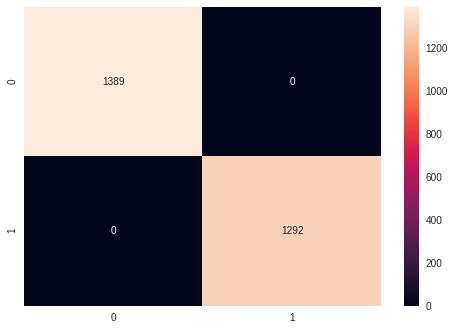

In [20]:
sns.heatmap(metrics.confusion_matrix(results[target],results['y_pred']),annot=True,fmt='d');

***How does the model think ?***

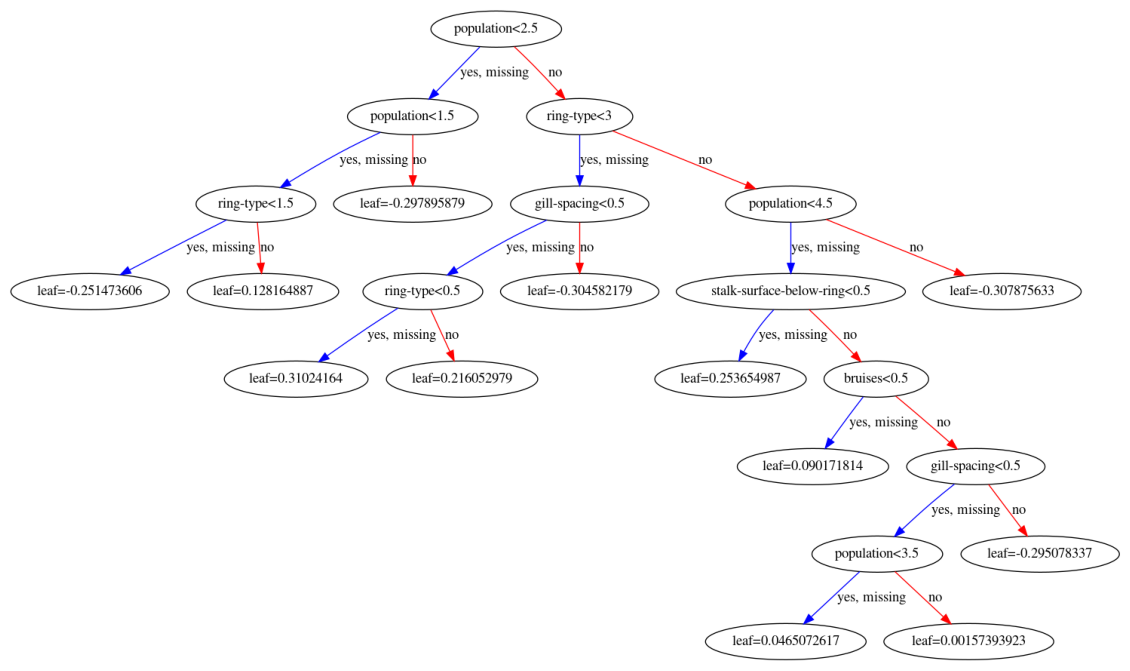

In [43]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
xgb.plot_tree(grid.best_estimator_,num_trees=10,ax=ax);

**Shap Values / Feature Impact**

In [24]:
expl = shap.TreeExplainer(grid.best_estimator_)

In [34]:
shap_values = expl.shap_values(test[features],test[target])

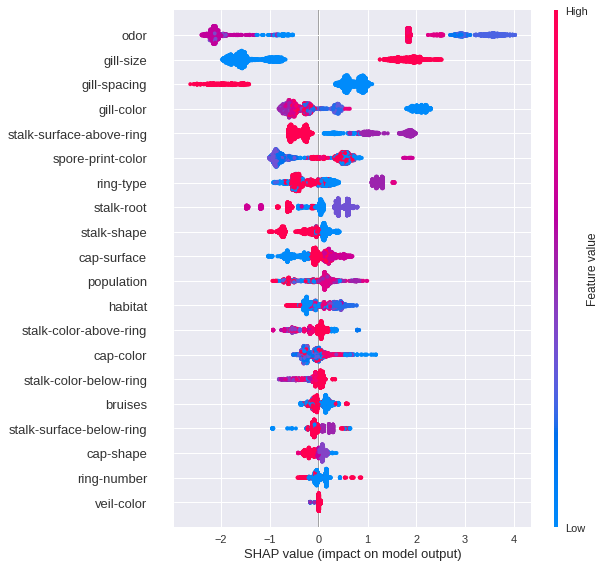

In [35]:
shap.summary_plot(shap_values,test[features])